# Feature Extraction (part 1)

In [1]:
import librosa
import matplotlib.pyplot as plt
import vocalpy as voc

/Users/tessa/opt/anaconda3/envs/acabb-env/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Acoustic features

In their simplest form, these area scalar value we compute *per frame* (time bin) of a spectrogram. For example:
* amplitude, intensity, energy: the sum of values across the frequencies, e.g. the [Root Mean Square](https://librosa.org/doc/0.10.2/generated/librosa.feature.rms.html#librosa.feature.rms) of the signal
* entropy: the Shannon entropy of the  $H(x, sf) =  -\sum_{f=0}^{f_s/2} P(f) \log_2[P(f)]$
* fundamental frequency / pitch: typically computed with an algorithm such as [YIN](https://librosa.org/doc/0.10.2/generated/librosa.yin.html#librosa.yin)

In [2]:
sound = voc.example('samba.wav', return_type="sound")

As an example we'll look at some features computed by [Sound Analysis Tools](http://soundanalysispro.com/matlab-sat).

The implementation in VocalPy is adapted from work by [Therese Koch](https://therese-koch.netlify.app/) in [AVN](https://github.com/theresekoch/avn/blob/main/avn/acoustics.py) and in [birdsonganalysis](https://github.com/PaulEcoffet/birdsonganalysis) by Paul Ecoffet.

We call the function `voc.feature.sat.similarity_features` with a `Sound`, and we get back a set of `vocalpy.Features`.

In [3]:
features = voc.feature.sat.similarity_features(sound)

In [4]:
features

vocalpy.Features(data=
<xarray.Dataset> Size: 92kB
Dimensions:               (channel: 1, time: 1637)
Coordinates:
  * channel               (channel) int64 8B 0
  * time                  (time) float64 13kB 0.004535 0.005442 ... 1.488 1.488
Data variables:
    amplitude             (channel, time) float64 13kB 30.72 31.91 ... -66.71
    pitch                 (channel, time) float64 13kB 8.82e+03 ... 8.82e+03
    goodness_of_pitch     (channel, time) float64 13kB 0.07121 ... 1.137e-15
    frequency_modulation  (channel, time) float64 13kB 1.57 1.569 ... -0.0 -0.0
    amplitude_modulation  (channel, time) float64 13kB 0.0007646 ... 0.0
    entropy               (channel, time) float64 13kB -1.355 -1.291 ... -0.3899
)

In [5]:
features.data.data_vars

Data variables:
    amplitude             (channel, time) float64 13kB 30.72 31.91 ... -66.71
    pitch                 (channel, time) float64 13kB 8.82e+03 ... 8.82e+03
    goodness_of_pitch     (channel, time) float64 13kB 0.07121 ... 1.137e-15
    frequency_modulation  (channel, time) float64 13kB 1.57 1.569 ... -0.0 -0.0
    amplitude_modulation  (channel, time) float64 13kB 0.0007646 ... 0.0
    entropy               (channel, time) float64 13kB -1.355 -1.291 ... -0.3899

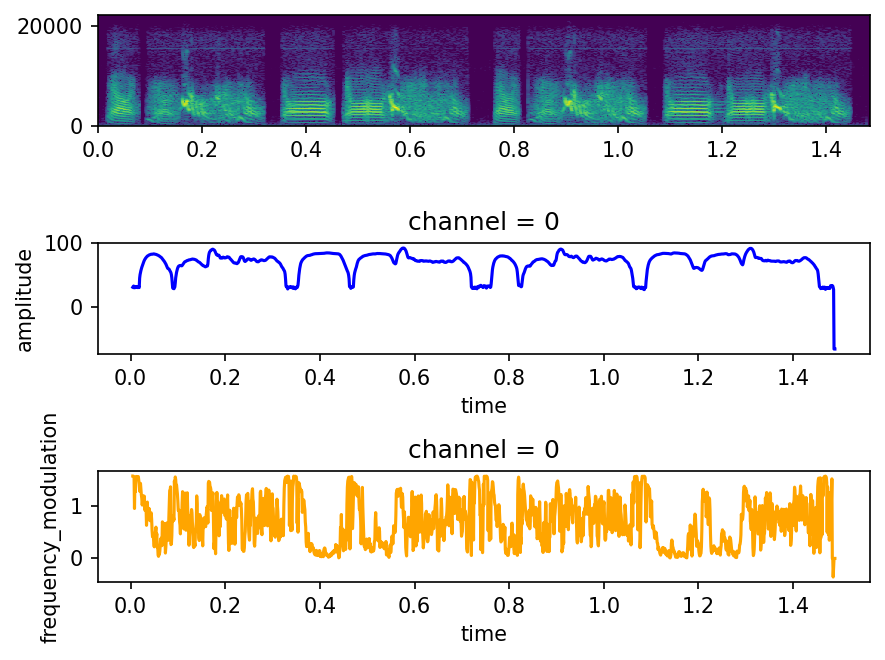

In [6]:
spect = voc.spectrogram(sound)

fig, ax_arr = plt.subplots(3, 1, figsize=(6, 4.5), dpi=150)

voc.plot.spectrogram(spect, ax=ax_arr[0])
features.data['amplitude'].plot(ax=ax_arr[1], color='b')
features.data['frequency_modulation'].plot(ax=ax_arr[2], color='orange')
fig.tight_layout()

Another use of features is to reduce entire *segments* -- e.g., calls, syllables, etc.--to a 1-dimensional vector of *features*. This gives us a *feature space* we can use with many methods that expect vectors: machine learning classification, dimensionality reduction, distance measures.


## Precomputed Acoustic Features


As defined in [Elie Theunissen 2016](https://link.springer.com/article/10.1007/s10071-015-0933-6): a set of extracted features, in contrast with higher dimensionality "features". 

A similar approach is taken by the [warbleR](https://marce10.github.io/warbleR/index.html) function [`spectro_analysis`](https://marce10.github.io/warbleR/reference/spectro_analysis.html).

In [7]:
wav_paths = voc.paths.from_dir(
    './data/Elie-Theunissen-2016-zebra-finch-song-library-subset/',
    'wav'
)

In [8]:
data, samplerate = librosa.load(wav_paths[0])
data = librosa.to_mono(data)
sound = voc.Sound(data, samplerate)

Here we get the set of features computed by `soundsig`(https://github.com/theunissenlab/soundsig).

In [9]:
# we skip computing fundamental frequency features since those are slower
out = voc.feature.soundsig.predefined_acoustic_features(sound, ftr_groups=("temporal", "spectral"))

In [10]:
out

<xarray.Dataset> Size: 120B
Dimensions:     (channel: 1)
Coordinates:
  * channel     (channel) int64 8B 0
Data variables: (12/14)
    mean_t      (channel) float64 8B 0.08842
    std_t       (channel) float64 8B 0.04664
    skew_t      (channel) float64 8B -0.007942
    kurtosis_t  (channel) float64 8B 1.701
    entropy_t   (channel) float64 8B 0.99
    max_amp     (channel) float64 8B 2.19e+03
    ...          ...
    skew_s      (channel) float64 8B 0.4442
    kurtosis_s  (channel) float64 8B 5.511
    entropy_s   (channel) float64 8B 0.6815
    q1          (channel) float64 8B 2.046e+03
    q2          (channel) float64 8B 3.661e+03
    q3          (channel) float64 8B 4.048e+03

Following the same pattern as before, we will use a `FeatureExtractor` class to extract features from many files.

In [11]:
callback = voc.feature.soundsig.predefined_acoustic_features
params = dict(ftr_groups=("temporal", "spectral"))
extractor = voc.FeatureExtractor(callback, params)

In [12]:
sounds = [voc.Sound.read(wav_path) for wav_path in wav_paths[:10]]
features_list = extractor.extract(sounds, parallelize=True)

[########################################] | 100% Completed | 105.92 ms


In [13]:
features_list[0]

vocalpy.Features(data=
<xarray.Dataset> Size: 240B
Dimensions:     (channel: 2)
Coordinates:
  * channel     (channel) int64 16B 0 1
Data variables: (12/14)
    mean_t      (channel) float64 16B 0.08641 0.09057
    std_t       (channel) float64 16B 0.04605 0.04736
    skew_t      (channel) float64 16B 0.08247 -0.1099
    kurtosis_t  (channel) float64 16B 1.73 1.715
    entropy_t   (channel) float64 16B 0.9898 0.9917
    max_amp     (channel) float64 16B 3.399e+03 1.458e+03
    ...          ...
    skew_s      (channel) float64 16B 0.3654 0.7014
    kurtosis_s  (channel) float64 16B 6.486 5.341
    entropy_s   (channel) float64 16B 0.7051 0.6799
    q1          (channel) float64 16B 2.67e+03 2.024e+03
    q2          (channel) float64 16B 3.79e+03 2.67e+03
    q3          (channel) float64 16B 4.048e+03 4.005e+03
)